## A decision support system for Glaucoma diagnosis.
### Model Selection 

We previously selected a set of best features for use in a model for predicting Glaucoma diagnoses. Here we'll test a simple predictive model: Logistic Regression.

The conclusion drawn from our feature selection is that the best set of features will likely be a pair representing a retinal test and a functional vision test. Adding more features is unlikely to improve prediction accuracy, may result in overfitting, and will likely yield implausible models due to the multicolinearity of the features.

Below we'll test the three best pairs of features determined by the feature selection.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from scipy.stats import norm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#import warnings
#warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

Load the dataset containing combined features ('cdr_avgt' and 'ght_psd').

In [2]:
df0 = pd.read_csv('~/Dropbox/BayesNet/Glaucoma_Data_Dec16_Plus.csv')
df0.drop('Unnamed: 0', axis=1, inplace=True)
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 13 columns):
glaucoma        597 non-null float64
age             597 non-null float64
race            597 non-null float64
male            597 non-null int64
cdratio         597 non-null float64
IOP             597 non-null float64
avgthickness    597 non-null int64
ght             597 non-null int64
vfi             597 non-null int64
mdonl           597 non-null int64
psdonl          597 non-null int64
cdr_avgt        597 non-null float64
ght_psd         597 non-null float64
dtypes: float64(7), int64(6)
memory usage: 60.7 KB


Define functions for leave-one-out cross validation, for returning the model prediction metrics, and for plotting data and decision boundaries.

In [3]:
# leave-one-out CV
def cv_loo(X, Y, model):
    y_pred = []
    p_pred = np.empty((0,2))
    for i in range(X.shape[0]):      
        ind = list(range(X.shape[0]))
        ind_tr = [j for j in ind if j != i]
        ind_te = i
        if X.shape[1] > 1:
            X_train = X[ind_tr, :]
            X_test = X[i, :]
        else:    
            X_train = X[ind_tr]
            X_test = X[i]
        Y_train = Y[ind_tr]
        Y_test = Y[i]
        model.fit(X_train, Y_train)
        y_pred.append(model.predict([X_test]))
        p_pred = np.vstack([p_pred,model.predict_proba([X_test])])
    result = {'y_pred': np.array(y_pred), 'y_true': Y, 'p_pred': p_pred}
    return result

# model performance
def results(y_test, y_pred, display):
    # accuracy, hits, true_negatives, misses, false_positives
    acc = sum(y_test == y_pred)/len(y_test)
    tpos = sum((y_test == 1) & (y_pred==1))/sum(y_test == 1)
    tneg = sum((y_test == 0) & (y_pred==0))/sum(y_test == 0)
    fneg = sum((y_test == 1) & (y_pred==0))/sum(y_test == 1)
    fpos = sum((y_test == 0) & (y_pred==1))/sum(y_test == 0)
    if display:
        # print the results
        print('accuracy = %.3f' % acc)
        print('hits = %.3f' % tpos)
        print('misses = %.3f' % fneg)
        print('true negatives = %.3f' % tneg)
        print('false positives = %.3f' % fpos)
    # save the results
    return {'acc': acc, 'tpos': tpos, 'tneg': tneg, 'fneg': fneg, 'fpos': fpos}

# plot decisions boundaries
def decision_bounds(scale_x, scale_y, df, features, target, model): 
    # extract features and targets
    X = df[features].values
    Y = df[target].values
    
    # get model predictions for all values
    xx, yy = np.meshgrid(scale_x, scale_y)
    XX = np.c_[xx.ravel(), yy.ravel()]
    pred = model.predict(XX)
    pred = pred.reshape(xx.shape)
    
    # plot decision bounds
    fig = plt.figure(figsize=(16, 8))
    fig.add_subplot(1,2,1)
    plt.set_cmap(plt.cm.Paired)
    plt.pcolormesh(xx, yy, pred)

    # plot the data
    plt.scatter(X[:, 0], X[:, 1], c=Y)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Decision Bounds')
    
    # clean up
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    fig.add_subplot(1,2,2)

    # color maps
    cmap_navy=sns.light_palette('navy', as_cmap=True)
    cmap_green=sns.light_palette('green', as_cmap=True)
    cmap_navy_pal=sns.light_palette('navy', as_cmap=False)
    cmap_green_pal=sns.light_palette('green', as_cmap=False)

    # plots
    sns.kdeplot(df0.loc[df[target]==1, features[0]], 
                df0.loc[df[target]==1, features[1]], cmap=cmap_navy)
    sns.kdeplot(df0.loc[df[target]==0, features[0]], 
                df0.loc[df[target]==0, features[1]], cmap=cmap_green)
    plt.title('Diagnosis distributions')
    plt.xlabel(features[0])
    plt.ylabel(features[1])

    plt.show()

In [4]:

features = ['cdr_avgt', 'psdonl']
print(df0.loc[0, features[0]])



0.940485760667


Now we'll fit a logistic regression models to the data using the 5 best pairs of features:

** CDR_AVGt | PSD**

** CDR_AVGt | GHT**

** CDR_AVGt | GHT_PSD**

** CDR | PSD**

** CDR | GHT**

## Logistic regression

#### CDR_AVGt and PSD

             coefs
cdr_avgt -0.936621
psdonl    0.696076


accuracy = 0.720
hits = 0.732
misses = 0.268
true negatives = 0.707
false positives = 0.293


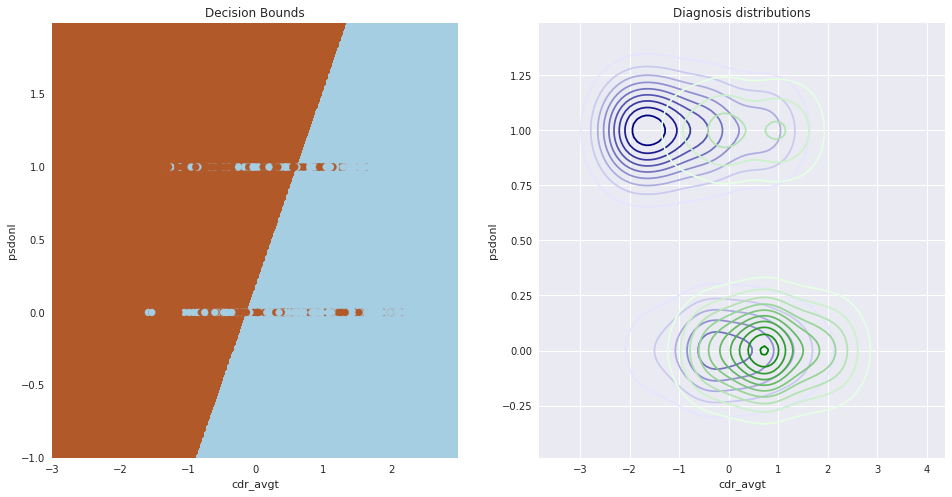

None


In [5]:
# get features and targets
features = ['cdr_avgt', 'psdonl']
X = df0[features].values
Y = df0['glaucoma'].values

# fit the model, get predictions
model = LogisticRegression()
fit = model.fit(X, Y)
pred = model.predict(X)
coefs = pd.DataFrame.from_dict(dict(zip(features, fit.coef_[0])), orient='index')
coefs.columns = ['coefs']

# print the results
print(coefs)
print('\n')
result = results(Y, pred, True)

# plot data and decision bounds
scale_x = np.arange(-3, 3, .01)
scale_y = np.arange(-1, 2, .01)
pred = decision_bounds(scale_x, scale_y, df0, features, 'glaucoma', model)

print(pred)


A simple linear model achieves about 72% accuracy. The regression coefficients are sensible: lower values of CDR_AVGt and high PSD values (i.e. '1') are associated with positive diagnoses.

In the plot, positive cases and predictions are shown in brown and negative cases in blue. There is substantial overlap between the diagnoses for these features. This is likely due to the relative indiscriminability of the diagnostic classes, i.e. doctors simply disagree on the diagnoses for similar cases. This decision noise places an upper limit on the maximum achievable accuracy of the classifier.

Let's continue testing our best feature pairs.

### CDR_AVGt and GHT

             coefs
cdr_avgt -0.917363
ght       0.430961


accuracy = 0.719
hits = 0.732
misses = 0.268
true negatives = 0.704
false positives = 0.296


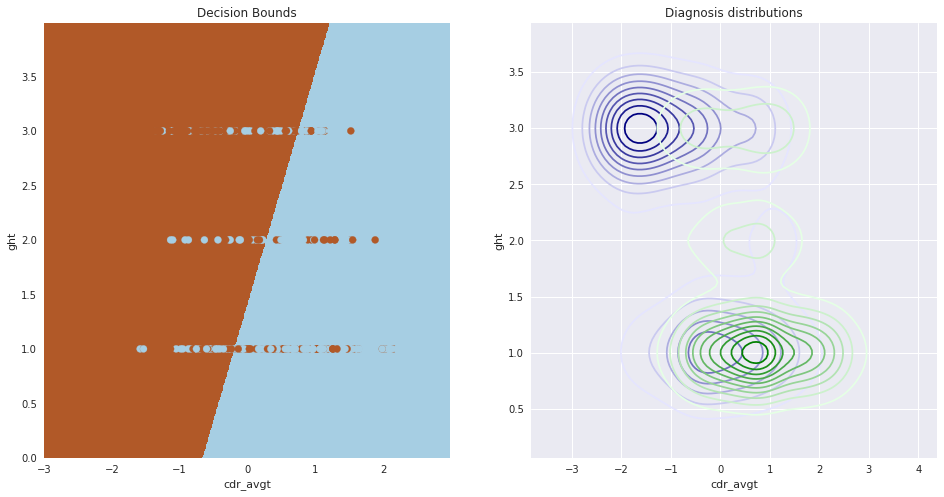

In [6]:
features = ['cdr_avgt', 'ght']
X = df0[features].values
Y = df0['glaucoma'].values

# fit the model, get predictions
model = LogisticRegression()
fit = model.fit(X, Y)
pred = model.predict(X)
coefs = pd.DataFrame.from_dict(dict(zip(features, fit.coef_[0])), orient='index')
coefs.columns = ['coefs']

# print the results
print(coefs)
print('\n')
result = results(Y, pred, True)

# plot data and decision bounds
scale_x = np.arange(-3, 3, .01)
scale_y = np.arange(0, 4, .01)
decision_bounds(scale_x, scale_y, df0, features, 'glaucoma', model)

### CDR_AVGt and GHT_PSD

             coefs
cdr_avgt -0.905436
ght_psd  -0.278591


accuracy = 0.719
hits = 0.726
misses = 0.274
true negatives = 0.711
false positives = 0.289


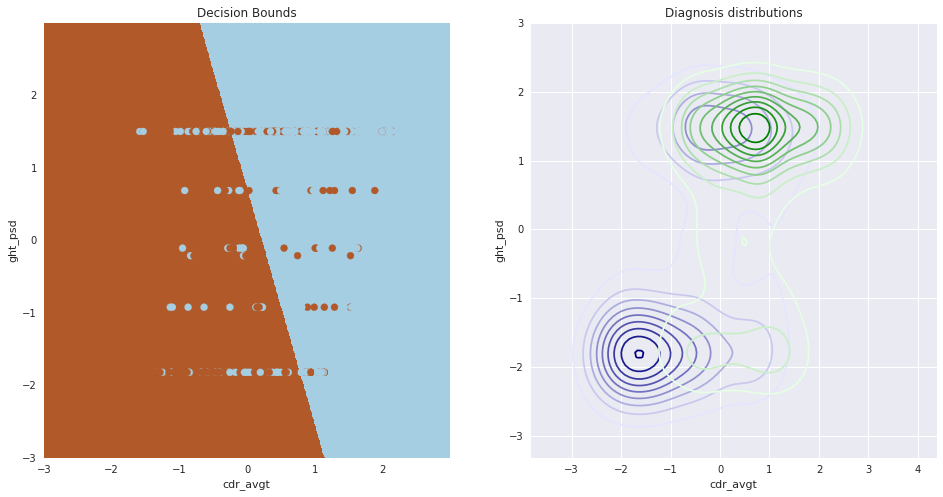

In [7]:
# get features and targets
features = ['cdr_avgt', 'ght_psd']
X = df0[features].values
Y = df0['glaucoma'].values

# fit the model, get predictions
model = LogisticRegression()
fit = model.fit(X, Y)
pred = model.predict(X)
coefs = pd.DataFrame.from_dict(dict(zip(features, fit.coef_[0])), orient='index')
coefs.columns = ['coefs']

# print the results
print(coefs)
print('\n')
result = results(Y, pred, True)

# plot data and decision bounds
scale_x = np.arange(-3, 3, .01)
scale_y = np.arange(-3, 3, .01)
decision_bounds(scale_x, scale_y, df0, features, 'glaucoma', model)

plt.show()

### CDR and PSD

            coefs
cdratio  2.917977
psdonl   1.076255


accuracy = 0.710
hits = 0.716
misses = 0.284
true negatives = 0.704
false positives = 0.296


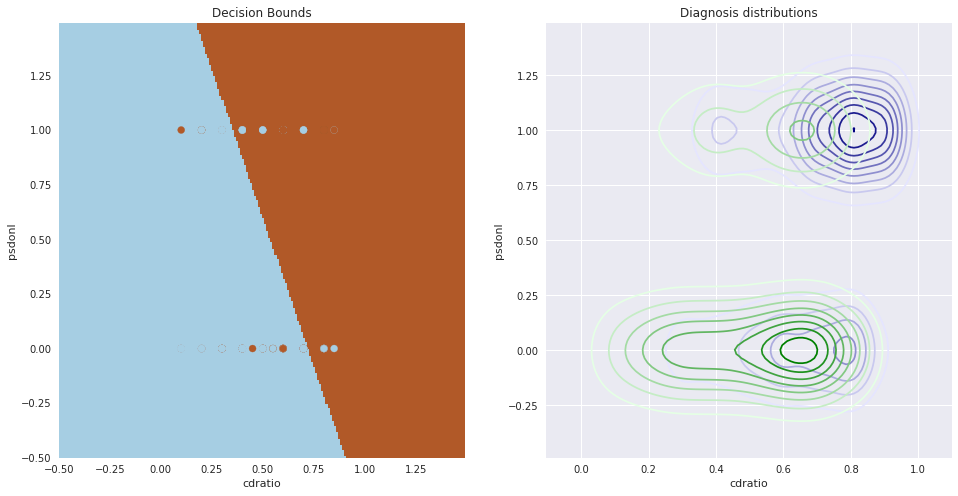

In [8]:
features = ['cdratio', 'psdonl']
X = df0[features].values
Y = df0['glaucoma'].values

# fit the model, get predictions
model = LogisticRegression()
fit = model.fit(X, Y)
pred = model.predict(X)
coefs = pd.DataFrame.from_dict(dict(zip(features, fit.coef_[0])), orient='index')
coefs.columns = ['coefs']

# print the results
print(coefs)
print('\n')
result = results(Y, pred, True)

# plot data and decision bounds
scale_x = np.arange(-.5, 1.5, .01)
scale_y = np.arange(-.5, 1.5, .01)
decision_bounds(scale_x, scale_y, df0, features, 'glaucoma', model)

### CDR and GHT

            coefs
cdratio  2.748859
ght      0.615684


accuracy = 0.692
hits = 0.703
misses = 0.297
true negatives = 0.679
false positives = 0.321


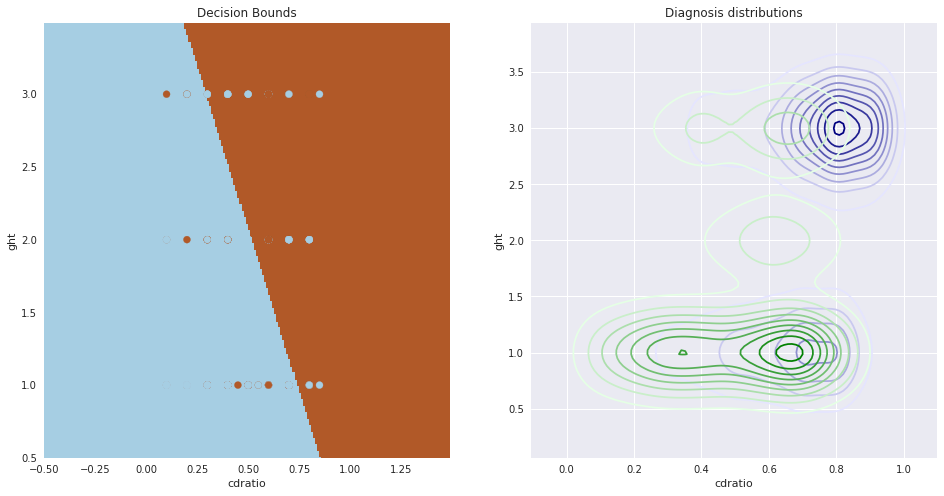

In [9]:
features = ['cdratio', 'ght']
X = df0[features].values
Y = df0['glaucoma'].values

# fit the model, get predictions
model = LogisticRegression()
fit = model.fit(X, Y)
pred = model.predict(X)
coefs = pd.DataFrame.from_dict(dict(zip(features, fit.coef_[0])), orient='index')
coefs.columns = ['coefs']

# print the results
print(coefs)
print('\n')
result = results(Y, pred, True)

# plot data and decision bounds
scale_x = np.arange(-.5, 1.5, .01)
scale_y = np.arange(.5, 3.5, .01)
decision_bounds(scale_x, scale_y, df0, features, 'glaucoma', model)

Next, we'll get the leave-one-out cross validated accuracy for each of the 5 models.

### Cross validation

In [10]:
# d prime
d_prime = lambda h,f: norm.ppf(h) - norm.ppf(f)

features = [['cdr_avgt', 'psdonl'],
            ['cdr_avgt', 'ght'],
            ['cdr_avgt', 'ght_psd'],
            ['cdratio', 'psdonl'],
            ['cdratio', 'ght']]
Y = df0['glaucoma'].values
dp = []
acc = []
hits= []
fps = []
probs = {}
for feature in range(len(features)):
    X = df0[features[feature]].values
    model = LogisticRegression()
    cv_result = cv_loo(X, Y, model)
    result = results(cv_result['y_true'], np.ravel(cv_result['y_pred']), False)
    acc.append(result['acc'])
    hits.append(result['tpos'])
    fps.append(result['fpos'])
    dp.append(d_prime(result['tpos'], result['fpos']))
    probs[feature] = cv_result['p_pred']

    
data = np.array([acc, hits, fps, dp]).T;
index = [' | '.join(f) for f in features]
columns = ['accuracy', 'Hits', 'FP', 'd\'']
table = pd.DataFrame(data, columns = columns, index = index)
table.head()


,accuracy,Hits,FP,d'
cdr_avgt | psdonl,0.716918,0.728707,0.296429,1.143606
cdr_avgt | ght,0.716918,0.728707,0.296429,1.143606
cdr_avgt | ght_psd,0.716918,0.725552,0.292857,1.144472
cdratio | psdonl,0.710218,0.716088,0.296429,1.105960
cdratio | ght,0.691792,0.703470,0.321429,0.998115


In [11]:
# write model predicitions to file for Bayes Net

# cross validated model predictions 
df0['cdr_avgt | psd'] = pd.Series(probs[0][:,1])
df0['cdr_avgt | ght'] = pd.Series(probs[1][:,1])
df0['cdr_avgt | ght_psd'] = pd.Series(probs[2][:,1])
df0['cdr | psd'] = pd.Series(probs[3][:,1])
df0['cdr | ght'] = pd.Series(probs[4][:,1])

df0.to_csv('~/Dropbox/BayesNet/Glaucoma_Data_Dec16_Plus_Model_Predictions.csv')
df0.head()

,glaucoma,age,race,male,cdratio,IOP,avgthickness,ght,vfi,mdonl,psdonl,cdr_avgt,ght_psd,cdr_avgt | psd,cdr_avgt | ght,cdr_avgt | ght_psd,cdr | psd,cdr | ght
0,0.0,47.978082,1.0,0,0.4,14.0,86,1,100,0,0,0.940486,1.496322,0.268375,0.262597,0.256691,0.284612,0.284006
1,1.0,69.904110,1.0,0,0.9,14.0,65,3,96,0,1,-1.765743,-1.821423,0.901862,0.909070,0.909009,0.832481,0.841712
2,1.0,79.142466,1.0,0,0.8,13.0,66,3,84,1,1,-1.384308,-1.821423,0.865362,0.875671,0.876088,0.787792,0.801574
3,0.0,55.158904,1.0,0,0.3,24.0,79,1,99,1,0,0.922393,1.496322,0.271716,0.265824,0.259830,0.229192,0.231671
4,0.0,61.843836,1.0,1,0.4,27.0,83,1,99,1,0,0.790663,1.496322,0.296816,0.290074,0.283434,0.284612,0.284006


Next we'll use the majority vote over the 5 models to classify positive and negative cases.

## Voting Classifier

In [13]:
# cross validate the majority vote classifier

X = df0.drop('glaucoma', axis=1).values
Y = df0['glaucoma'].values
d_prime = lambda h,f: norm.ppf(h) - norm.ppf(f)

# modified LOO CV function
def cv_loo_vote(X, Y, model):
    y_pred = []
    for i in range(X.shape[0]):      
        ind = list(range(X.shape[0]))
        ind_tr = [j for j in ind if j != i]
        ind_te = i
        if X.shape[1] > 1:
            X_train = X[ind_tr, :]
            X_test = X[i, :]
        else:    
            X_train = X[ind_tr]
            X_test = X[i]
        Y_train = Y[ind_tr]
        Y_test = Y[i]
        model.fit(X_train, Y_train)
        y_pred.append(model.predict(X_test.reshape(1,-1)))
    result = {'y_pred': np.array(y_pred), 'y_true': Y}
    return result

# psd and cdr_avgt
pipe1 = make_pipeline(ColumnSelector(cols=(9, 10)),LogisticRegression())
# ght and cdr_avgt
pipe2 = make_pipeline(ColumnSelector(cols=(6, 10)),LogisticRegression())
# ght_psd and cdr_avgt
pipe3 = make_pipeline(ColumnSelector(cols=(11, 10)),LogisticRegression())
# cdr psd 
pipe4 = make_pipeline(ColumnSelector(cols=(3, 9)),LogisticRegression())
# cdr ght
pipe5 = make_pipeline(ColumnSelector(cols=(3, 6)),LogisticRegression())

est = [('lr1', pipe1), ('lr2', pipe2), ('lr3', pipe3), ('lr4', pipe4)]
eclf = VotingClassifier(estimators=est, voting='hard')

# cross validate
cv_results = cv_loo_vote(X, Y, eclf)
result = results(cv_results['y_true'], np.ravel(cv_results['y_pred']), True)
print('d prime: ', d_prime(result['tpos'], result['fpos']))

accuracy = 0.725
hits = 0.729
misses = 0.271
true negatives = 0.721
false positives = 0.279
d prime:  1.1959965991


The voting classifier using the first 4 models acheives slighty higher accuracy and discriminability than any of the models individually.
